# **Detection**

**Subsections:**
- **Pre-processing:** `BackgroundSubtractorMOG2`
- **Processing:** `HoughCircle`
- **Post-processing**

In [108]:
# Import required libraries
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

Loading the video file

- _notebook_dir -> /home/davic/projects/IACV_project/bowling-analysis/notebook/ball_detection_
- _project_root -> /home/davic/projects/IACV_project/bowling-analysis_
- _video_path   -> /home/davic/projects/IACV_project/bowling-analysis/data/recording_2/Recording_2_normal_speed.mp4_

In [ ]:
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / "recording_2" / "Recording_2.mp4"
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 276.0


## Pre-processing

Auxiliary functions

In [110]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

I read one frame in order to test the techniques

In [111]:
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 100)
ret, frame = cap.read()
if not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

**Techniques for pre-processing**

For Recording_3 I have tryed:

- `bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=450, varThreshold=20, detectShadows=True)`
- `bg_subtractor.setVarThresholdGen(35)`

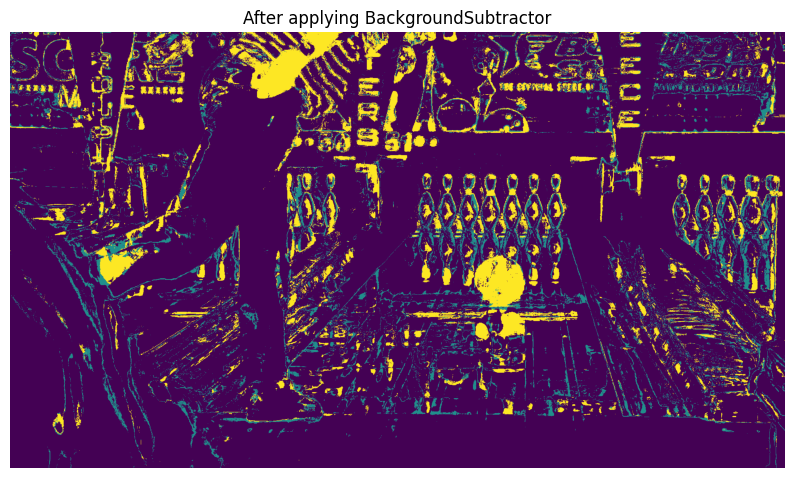

In [112]:
# Initialize background subtractor
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)
bg_subtractor.setVarThresholdGen(25)

'''
history ->  Higher value → More stable background model (good for static scenes).
            Lower value → Faster adaptation to changes (good for dynamic scenes).
varThreshold -> Higher value → Only very different pixels are considered foreground.
                Lower value → More sensitive to small changes (can lead to noise).
varThresholdGen ->  Higher value → Background adapts slower.
                    Lower value → Background adapts faster.
'''

# Reset the cap to the initial frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Warm-up: Read first n-40 frames to build the background model
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-40):
    ret, frame_bg = cap.read()
    if not ret: break
    bg_subtractor.apply(frame_bg)

# Apply background subtraction
fg_mask = bg_subtractor.apply(frame)

showImage(fg_mask, "After applying BackgroundSubtractor")

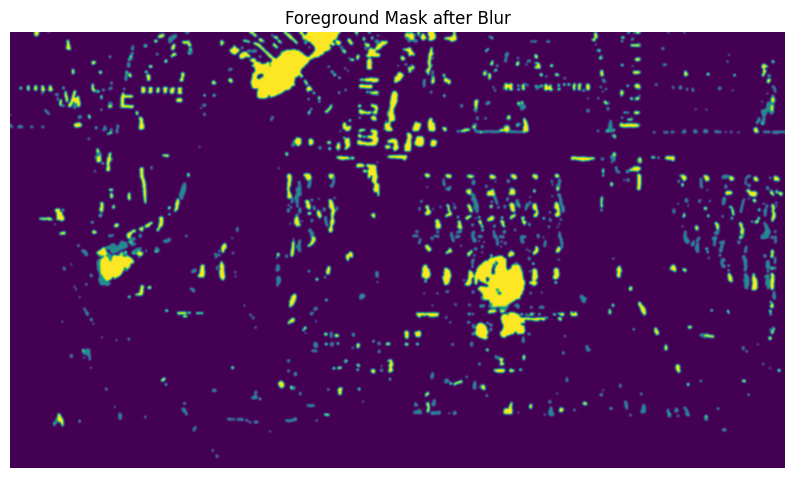

In [113]:
# Morphological operations to reduce noise
kernel = np.ones((5, 5), np.uint8)
thresh = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
thresh = cv2.medianBlur(thresh, 5)
blurred = cv2.GaussianBlur(thresh, (9, 9), 2)

showImage(blurred, "Foreground Mask after Blur")

In [114]:
cap.release()

## Processing

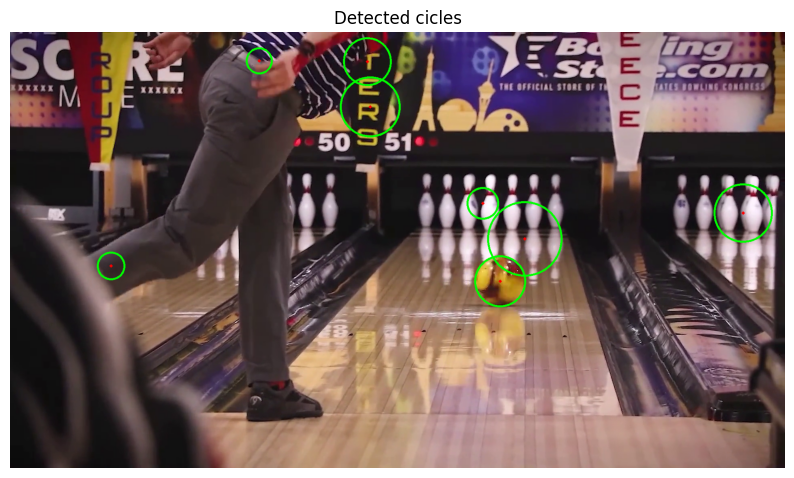

In [115]:
# Hough Circle Detection
circles = cv2.HoughCircles(
    blurred, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2,  # Inverse ratio of resolution
    minDist=100,  # Minimum distance between detected centers
    param1=50,  # Higher threshold for Canny edge detector
    param2=30,  # Accumulator threshold for circle detection
    minRadius=30,  # Minimum radius of detected circles
    maxRadius=100   # Maximum radius of detected circles
)

# Draw circles if detected
if circles is not None:
    circles = np.uint16(np.around(circles))
    output = frame.copy()
    for i in circles[0, :]:
        cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 3)  # Draw circle
        cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)  # Draw center

    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    showImage(output_rgb, "Detected cicles")
else:
    print("No circles detected")


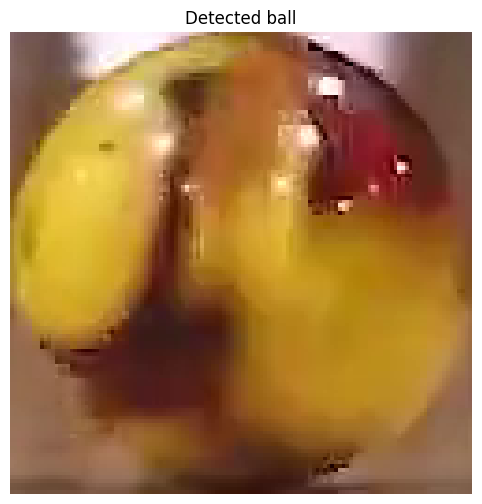

In [116]:
if circles is not None:
    x, y, r = circles[0, 0]  # Get first detected circle
    ball = frame[y-r:y+r, x-r:x+r]  # Crop the ball region
    if ball.size > 0:
        ball_rgb = cv2.cvtColor(ball, cv2.COLOR_BGR2RGB)
        showImage(ball_rgb, "Detected ball")